In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap
from sklearn.utils.class_weight import compute_class_weight

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-16 05:45:33.645688: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 05:45:33.688519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 05:45:37.568385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0816_variable.csv')
test = pd.read_csv('./data/test_0816_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'stage1_dist_cat', 'stage2_dist_cat',
       'stage3_dist_cat', 'cure_time_dam', 'cure_time_fill2',
       'press21_autoclave', 'thon_time', 'discharged_dist_stage1_dam',
       'discharged_dist_stage2_dam', 'discharged_dist_stage3_dam',
       'discharged_dist_stage1_fill1', 'discharged_dist_stage2_fill1',
       'discharged_dist_stage3_fill1', 'equip', 'fill2_time', 'autoclave_time',
       'qty', 'thick1', 'thick2', 'thick3', 'chamber_temp', 'model_suffix',
       'select_workorder', 'select_pallet', 'direction', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3'],
      dtype='object')

In [6]:
# 학습시 inconsistant 전부 빼고 적용
train_sel = train[train['inconsistant'] == 0]

In [7]:
# 각 영역별 
stage1 = ['target', 'stage1_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time',
       'thick1', 'volume_ratio_stage1',
       'discharged_dist_stage1_dam', 'discharged_dist_stage1_fill1',
       'select_pallet', 'select_workorder', 'direction', 'equip'
]

stage2 = [
        'target', 
       'stage2_dist_cat', 
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'thick2', 'volume_ratio_stage2',
       'discharged_dist_stage2_dam', 'discharged_dist_stage2_fill1',
       'select_pallet', 'select_workorder', 'direction', 'equip'
]

stage3 = [
        'target', 'stage3_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'fill2_time', 'thick3', 'volume_ratio_stage3',
       'discharged_dist_stage3_dam', 'discharged_dist_stage3_fill1',
       'select_pallet', 'select_workorder', 'direction', 'equip'
]

autoclave = [
        'target',
       'press21_autoclave',
        'autoclave_time', 'select_pallet', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3', 
       'chamber_temp', 'select_workorder'
            ]

df_stage1 = train_sel[stage1]
df_stage2 = train_sel[stage2]
df_stage3 = train_sel[stage3]
df_autoclave = train_sel[autoclave]

# Stage1

In [8]:
X_stage1 = df_stage1.drop(columns=['target'])
y_stage1 = df_stage1['target']

cat_features_indices_stage1 = ['select_pallet', 'stage1_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage1, y_stage1, test_size=0.2, random_state=42, stratify = y_stage1)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage1)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage1)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
# Sampler 생성 시 random seed 설정
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 05:45:42,928] A new study created in memory with name: no-name-67d66e90-c73b-4c19-8809-ec612b9ebb3d
[I 2024-08-16 05:45:44,999] Trial 0 finished with value: 0.5611764428017941 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5611764428017941.
[I 2024-08-16 05:45:48,459] Trial 1 finished with value: 0.5623358691826624 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 1 with value: 0.5623358691826624.
[I 2024-08-16

[I 2024-08-16 05:46:43,899] Trial 19 finished with value: 0.5676782779834034 and parameters: {'iterations': 221, 'depth': 4, 'learning_rate': 0.11661400098075028, 'l2_leaf_reg': 2.184629888815115, 'border_count': 38, 'random_strength': 8.506171326562402, 'bagging_temperature': 0.1922504770390767, 'od_type': 'Iter', 'od_wait': 50, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 6 with value: 0.578512423442832.
[I 2024-08-16 05:46:46,086] Trial 20 finished with value: 0.5618672912063492 and parameters: {'iterations': 390, 'depth': 7, 'learning_rate': 0.33318639267709144, 'l2_leaf_reg': 7.110882628950337, 'border_count': 206, 'random_strength': 9.974698284812263, 'bagging_temperature': 0.36527195364306986, 'od_type': 'Iter', 'od_wait': 34, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 6 with value: 0.578512423442832.
[I 2024-08-16 05:46:47,128] Trial 21 finished with value: 0.5641548655911311 and parameters: {'iterations': 614, 'depth': 4, 'learning_r

[I 2024-08-16 05:47:26,281] Trial 38 finished with value: 0.5706597101005346 and parameters: {'iterations': 521, 'depth': 5, 'learning_rate': 0.15703379995482908, 'l2_leaf_reg': 7.611133535081899, 'border_count': 254, 'random_strength': 0.9787890542376427, 'bagging_temperature': 0.16485929862564142, 'od_type': 'Iter', 'od_wait': 36, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 24 with value: 0.5796651374730442.
[I 2024-08-16 05:47:27,440] Trial 39 finished with value: 0.5655102410036775 and parameters: {'iterations': 194, 'depth': 5, 'learning_rate': 0.03231002409574897, 'l2_leaf_reg': 8.945811396473989, 'border_count': 61, 'random_strength': 1.208919670718608, 'bagging_temperature': 0.14235471121193208, 'od_type': 'Iter', 'od_wait': 25, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 24 with value: 0.5796651374730442.
[I 2024-08-16 05:47:29,126] Trial 40 finished with value: 0.560471413376149 and parameters: {'iterations': 525, 'depth': 6, 'learnin

Best trial:
  Value: 0.5796651374730442
  Params: 
    iterations: 715
    depth: 4
    learning_rate: 0.21731939976796613
    l2_leaf_reg: 8.638339917051571
    border_count: 254
    random_strength: 6.633076645300532
    bagging_temperature: 0.19605347057566258
    od_type: Iter
    od_wait: 35
    boosting_type: Ordered
    scale_pos_weight: 6


In [9]:
study.best_trial.params

{'iterations': 715,
 'depth': 4,
 'learning_rate': 0.21731939976796613,
 'l2_leaf_reg': 8.638339917051571,
 'border_count': 254,
 'random_strength': 6.633076645300532,
 'bagging_temperature': 0.19605347057566258,
 'od_type': 'Iter',
 'od_wait': 35,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 6}

In [10]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = study.best_trial.params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage1)

0:	learn: 0.6255698	total: 16.7ms	remaining: 11.9s
1:	learn: 0.5683456	total: 33.3ms	remaining: 11.9s
2:	learn: 0.5489910	total: 46.6ms	remaining: 11.1s
3:	learn: 0.5400571	total: 63.8ms	remaining: 11.3s
4:	learn: 0.5315125	total: 81.3ms	remaining: 11.5s
5:	learn: 0.5230572	total: 97.2ms	remaining: 11.5s
6:	learn: 0.5179262	total: 113ms	remaining: 11.4s
7:	learn: 0.5171411	total: 123ms	remaining: 10.9s
8:	learn: 0.5156990	total: 137ms	remaining: 10.8s
9:	learn: 0.5147858	total: 153ms	remaining: 10.8s
10:	learn: 0.5142886	total: 170ms	remaining: 10.9s
11:	learn: 0.5131919	total: 186ms	remaining: 10.9s
12:	learn: 0.5126134	total: 203ms	remaining: 11s
13:	learn: 0.5125788	total: 212ms	remaining: 10.6s
14:	learn: 0.5125576	total: 223ms	remaining: 10.4s
15:	learn: 0.5125275	total: 235ms	remaining: 10.3s
16:	learn: 0.5125196	total: 245ms	remaining: 10s
17:	learn: 0.5124275	total: 261ms	remaining: 10.1s
18:	learn: 0.5124246	total: 270ms	remaining: 9.91s
19:	learn: 0.5119486	total: 287ms	remai

163:	learn: 0.5053720	total: 2.5s	remaining: 8.4s
164:	learn: 0.5053716	total: 2.51s	remaining: 8.38s
165:	learn: 0.5053709	total: 2.53s	remaining: 8.36s
166:	learn: 0.5053709	total: 2.54s	remaining: 8.34s
167:	learn: 0.5053701	total: 2.56s	remaining: 8.33s
168:	learn: 0.5053701	total: 2.57s	remaining: 8.31s
169:	learn: 0.5053698	total: 2.59s	remaining: 8.29s
170:	learn: 0.5053696	total: 2.6s	remaining: 8.27s
171:	learn: 0.5053691	total: 2.61s	remaining: 8.25s
172:	learn: 0.5053689	total: 2.63s	remaining: 8.23s
173:	learn: 0.5053681	total: 2.64s	remaining: 8.21s
174:	learn: 0.5053677	total: 2.66s	remaining: 8.2s
175:	learn: 0.5053675	total: 2.67s	remaining: 8.18s
176:	learn: 0.5053675	total: 2.68s	remaining: 8.16s
177:	learn: 0.5053343	total: 2.7s	remaining: 8.14s
178:	learn: 0.5053342	total: 2.71s	remaining: 8.13s
179:	learn: 0.5053336	total: 2.73s	remaining: 8.11s
180:	learn: 0.5053336	total: 2.74s	remaining: 8.09s
181:	learn: 0.5053127	total: 2.76s	remaining: 8.08s
182:	learn: 0.505

325:	learn: 0.5038354	total: 4.79s	remaining: 5.72s
326:	learn: 0.5038222	total: 4.81s	remaining: 5.71s
327:	learn: 0.5038222	total: 4.82s	remaining: 5.69s
328:	learn: 0.5038142	total: 4.84s	remaining: 5.67s
329:	learn: 0.5038097	total: 4.85s	remaining: 5.66s
330:	learn: 0.5038096	total: 4.86s	remaining: 5.64s
331:	learn: 0.5038096	total: 4.88s	remaining: 5.63s
332:	learn: 0.5038096	total: 4.89s	remaining: 5.61s
333:	learn: 0.5037948	total: 4.91s	remaining: 5.59s
334:	learn: 0.5037948	total: 4.92s	remaining: 5.58s
335:	learn: 0.5037948	total: 4.93s	remaining: 5.56s
336:	learn: 0.5037948	total: 4.95s	remaining: 5.55s
337:	learn: 0.5037948	total: 4.96s	remaining: 5.53s
338:	learn: 0.5037901	total: 4.97s	remaining: 5.52s
339:	learn: 0.5037900	total: 4.99s	remaining: 5.5s
340:	learn: 0.5037846	total: 5s	remaining: 5.49s
341:	learn: 0.5037845	total: 5.02s	remaining: 5.47s
342:	learn: 0.5037831	total: 5.03s	remaining: 5.46s
343:	learn: 0.5037831	total: 5.05s	remaining: 5.44s
344:	learn: 0.50

484:	learn: 0.5033782	total: 7.01s	remaining: 3.32s
485:	learn: 0.5033782	total: 7.02s	remaining: 3.31s
486:	learn: 0.5033758	total: 7.04s	remaining: 3.29s
487:	learn: 0.5033758	total: 7.05s	remaining: 3.28s
488:	learn: 0.5033728	total: 7.07s	remaining: 3.27s
489:	learn: 0.5033728	total: 7.08s	remaining: 3.25s
490:	learn: 0.5033724	total: 7.09s	remaining: 3.24s
491:	learn: 0.5033647	total: 7.11s	remaining: 3.22s
492:	learn: 0.5033608	total: 7.13s	remaining: 3.21s
493:	learn: 0.5033607	total: 7.14s	remaining: 3.19s
494:	learn: 0.5033605	total: 7.15s	remaining: 3.18s
495:	learn: 0.5033598	total: 7.17s	remaining: 3.16s
496:	learn: 0.5033596	total: 7.18s	remaining: 3.15s
497:	learn: 0.5033595	total: 7.19s	remaining: 3.13s
498:	learn: 0.5033595	total: 7.2s	remaining: 3.12s
499:	learn: 0.5033575	total: 7.22s	remaining: 3.1s
500:	learn: 0.5033573	total: 7.23s	remaining: 3.09s
501:	learn: 0.5033572	total: 7.25s	remaining: 3.07s
502:	learn: 0.5033572	total: 7.26s	remaining: 3.06s
503:	learn: 0.

644:	learn: 0.5028315	total: 9.28s	remaining: 1.01s
645:	learn: 0.5028315	total: 9.3s	remaining: 993ms
646:	learn: 0.5028312	total: 9.31s	remaining: 979ms
647:	learn: 0.5028295	total: 9.33s	remaining: 964ms
648:	learn: 0.5028273	total: 9.34s	remaining: 950ms
649:	learn: 0.5028264	total: 9.35s	remaining: 935ms
650:	learn: 0.5028263	total: 9.37s	remaining: 921ms
651:	learn: 0.5028263	total: 9.38s	remaining: 906ms
652:	learn: 0.5028263	total: 9.39s	remaining: 892ms
653:	learn: 0.5028253	total: 9.41s	remaining: 878ms
654:	learn: 0.5028248	total: 9.42s	remaining: 863ms
655:	learn: 0.5028242	total: 9.44s	remaining: 849ms
656:	learn: 0.5028239	total: 9.45s	remaining: 834ms
657:	learn: 0.5028236	total: 9.46s	remaining: 820ms
658:	learn: 0.5028235	total: 9.48s	remaining: 805ms
659:	learn: 0.5028207	total: 9.49s	remaining: 791ms
660:	learn: 0.5027888	total: 9.51s	remaining: 777ms
661:	learn: 0.5027887	total: 9.52s	remaining: 762ms
662:	learn: 0.5027876	total: 9.53s	remaining: 748ms
663:	learn: 0

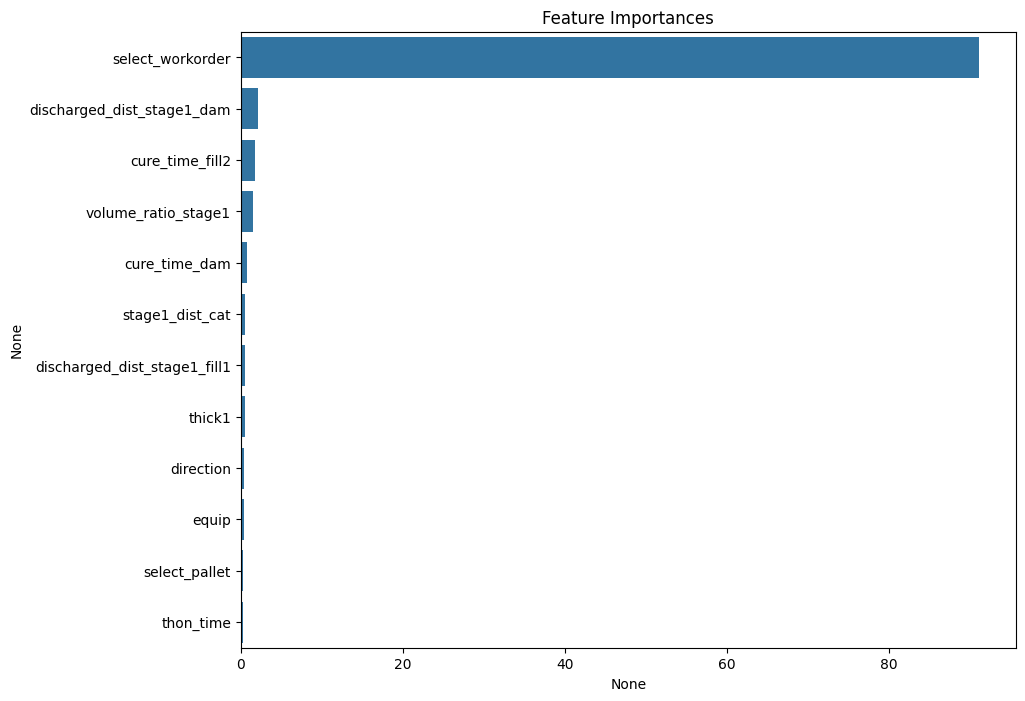

In [11]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [12]:
pred = stage1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  98  353]
 [ 383 7249]]

정확도: 0.9089
정밀도: 0.2037
재현율: 0.2173
F1: 0.2103


# Stage2

In [13]:
X_stage2 = df_stage2.drop(columns=['target'])
y_stage2 = df_stage2['target']

cat_features_indices_stage2 = ['select_pallet', 'stage2_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage2, y_stage2, test_size=0.2, random_state=42, stratify = y_stage2)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage2)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage2)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 05:47:49,675] A new study created in memory with name: no-name-a4746e3b-1864-4670-9abd-78800da0e725
[I 2024-08-16 05:47:50,881] Trial 0 finished with value: 0.56174122786879 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.56174122786879.
[I 2024-08-16 05:47:53,767] Trial 1 finished with value: 0.5615367225504463 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.56174122786879.
[I 2024-08-16 05:47

[I 2024-08-16 05:48:47,708] Trial 19 finished with value: 0.5626884456653477 and parameters: {'iterations': 798, 'depth': 8, 'learning_rate': 0.11611084533749048, 'l2_leaf_reg': 1.897780541346746, 'border_count': 218, 'random_strength': 5.3117226286289805, 'bagging_temperature': 0.704087094654376, 'od_type': 'IncToDec', 'od_wait': 32, 'boosting_type': 'Plain', 'scale_pos_weight': 8}. Best is trial 13 with value: 0.5709279760896853.
[I 2024-08-16 05:48:48,882] Trial 20 finished with value: 0.5650434795086672 and parameters: {'iterations': 650, 'depth': 5, 'learning_rate': 0.24361344906986787, 'l2_leaf_reg': 5.425084928735368, 'border_count': 186, 'random_strength': 9.974698284812263, 'bagging_temperature': 0.5554293691595693, 'od_type': 'IncToDec', 'od_wait': 28, 'boosting_type': 'Plain', 'scale_pos_weight': 6}. Best is trial 13 with value: 0.5709279760896853.
[I 2024-08-16 05:48:49,867] Trial 21 finished with value: 0.5758338212711425 and parameters: {'iterations': 549, 'depth': 4, 'le

[I 2024-08-16 05:49:15,074] Trial 38 finished with value: 0.5638634781835485 and parameters: {'iterations': 309, 'depth': 4, 'learning_rate': 0.15703379995482908, 'l2_leaf_reg': 0.7434060607140857, 'border_count': 137, 'random_strength': 5.754058936363218, 'bagging_temperature': 0.6634177333066054, 'od_type': 'Iter', 'od_wait': 44, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 24 with value: 0.5774455258199684.
[I 2024-08-16 05:49:15,729] Trial 39 finished with value: 0.5619293569696752 and parameters: {'iterations': 173, 'depth': 4, 'learning_rate': 0.010782977810011486, 'l2_leaf_reg': 0.5846844978430344, 'border_count': 184, 'random_strength': 2.1433711241728983, 'bagging_temperature': 0.020166303421811194, 'od_type': 'Iter', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 6}. Best is trial 24 with value: 0.5774455258199684.
[I 2024-08-16 05:49:16,567] Trial 40 finished with value: 0.5705592188087077 and parameters: {'iterations': 236, 'depth': 4, 'le

Best trial:
  Value: 0.5774455258199684
  Params: 
    iterations: 362
    depth: 6
    learning_rate: 0.11520356459611936
    l2_leaf_reg: 1.2780666892055916
    border_count: 216
    random_strength: 6.290487734617082
    bagging_temperature: 0.4225069304205283
    od_type: IncToDec
    od_wait: 40
    boosting_type: Plain
    scale_pos_weight: 6


In [14]:
study.best_trial.params

{'iterations': 362,
 'depth': 6,
 'learning_rate': 0.11520356459611936,
 'l2_leaf_reg': 1.2780666892055916,
 'border_count': 216,
 'random_strength': 6.290487734617082,
 'bagging_temperature': 0.4225069304205283,
 'od_type': 'IncToDec',
 'od_wait': 40,
 'boosting_type': 'Plain',
 'scale_pos_weight': 6}

In [15]:
# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = study.best_trial.params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage2)

0:	learn: 0.6547285	total: 13ms	remaining: 4.7s
1:	learn: 0.6089916	total: 26.3ms	remaining: 4.73s
2:	learn: 0.5800909	total: 39.2ms	remaining: 4.69s
3:	learn: 0.5655259	total: 50ms	remaining: 4.48s
4:	learn: 0.5574035	total: 61.8ms	remaining: 4.41s
5:	learn: 0.5478259	total: 73.9ms	remaining: 4.39s
6:	learn: 0.5432538	total: 82.2ms	remaining: 4.17s
7:	learn: 0.5397720	total: 90.9ms	remaining: 4.02s
8:	learn: 0.5369430	total: 97.5ms	remaining: 3.82s
9:	learn: 0.5318120	total: 110ms	remaining: 3.87s
10:	learn: 0.5280970	total: 121ms	remaining: 3.87s
11:	learn: 0.5254098	total: 131ms	remaining: 3.81s
12:	learn: 0.5244984	total: 136ms	remaining: 3.66s
13:	learn: 0.5235561	total: 148ms	remaining: 3.67s
14:	learn: 0.5227420	total: 160ms	remaining: 3.71s
15:	learn: 0.5223103	total: 167ms	remaining: 3.62s
16:	learn: 0.5218901	total: 177ms	remaining: 3.59s
17:	learn: 0.5183846	total: 186ms	remaining: 3.54s
18:	learn: 0.5169864	total: 196ms	remaining: 3.55s
19:	learn: 0.5147030	total: 208ms	rem

169:	learn: 0.4882282	total: 1.81s	remaining: 2.04s
170:	learn: 0.4879074	total: 1.82s	remaining: 2.04s
171:	learn: 0.4876212	total: 1.83s	remaining: 2.03s
172:	learn: 0.4874553	total: 1.85s	remaining: 2.02s
173:	learn: 0.4871340	total: 1.86s	remaining: 2.01s
174:	learn: 0.4869062	total: 1.87s	remaining: 2s
175:	learn: 0.4866281	total: 1.88s	remaining: 1.99s
176:	learn: 0.4865826	total: 1.9s	remaining: 1.98s
177:	learn: 0.4865439	total: 1.91s	remaining: 1.97s
178:	learn: 0.4864007	total: 1.92s	remaining: 1.96s
179:	learn: 0.4863662	total: 1.93s	remaining: 1.95s
180:	learn: 0.4861223	total: 1.94s	remaining: 1.94s
181:	learn: 0.4859190	total: 1.96s	remaining: 1.94s
182:	learn: 0.4857623	total: 1.97s	remaining: 1.92s
183:	learn: 0.4856061	total: 1.98s	remaining: 1.91s
184:	learn: 0.4855351	total: 1.99s	remaining: 1.9s
185:	learn: 0.4854636	total: 2s	remaining: 1.89s
186:	learn: 0.4853501	total: 2.01s	remaining: 1.88s
187:	learn: 0.4852933	total: 2.02s	remaining: 1.87s
188:	learn: 0.485182

329:	learn: 0.4676335	total: 3.73s	remaining: 362ms
330:	learn: 0.4675243	total: 3.75s	remaining: 351ms
331:	learn: 0.4673234	total: 3.76s	remaining: 340ms
332:	learn: 0.4672916	total: 3.77s	remaining: 328ms
333:	learn: 0.4672291	total: 3.78s	remaining: 317ms
334:	learn: 0.4671373	total: 3.79s	remaining: 306ms
335:	learn: 0.4670628	total: 3.81s	remaining: 295ms
336:	learn: 0.4668976	total: 3.82s	remaining: 283ms
337:	learn: 0.4668828	total: 3.83s	remaining: 272ms
338:	learn: 0.4668012	total: 3.84s	remaining: 261ms
339:	learn: 0.4666989	total: 3.85s	remaining: 250ms
340:	learn: 0.4666935	total: 3.87s	remaining: 238ms
341:	learn: 0.4666605	total: 3.88s	remaining: 227ms
342:	learn: 0.4666344	total: 3.89s	remaining: 216ms
343:	learn: 0.4666147	total: 3.9s	remaining: 204ms
344:	learn: 0.4665895	total: 3.91s	remaining: 193ms
345:	learn: 0.4665791	total: 3.92s	remaining: 182ms
346:	learn: 0.4665275	total: 3.94s	remaining: 170ms
347:	learn: 0.4665017	total: 3.95s	remaining: 159ms
348:	learn: 0

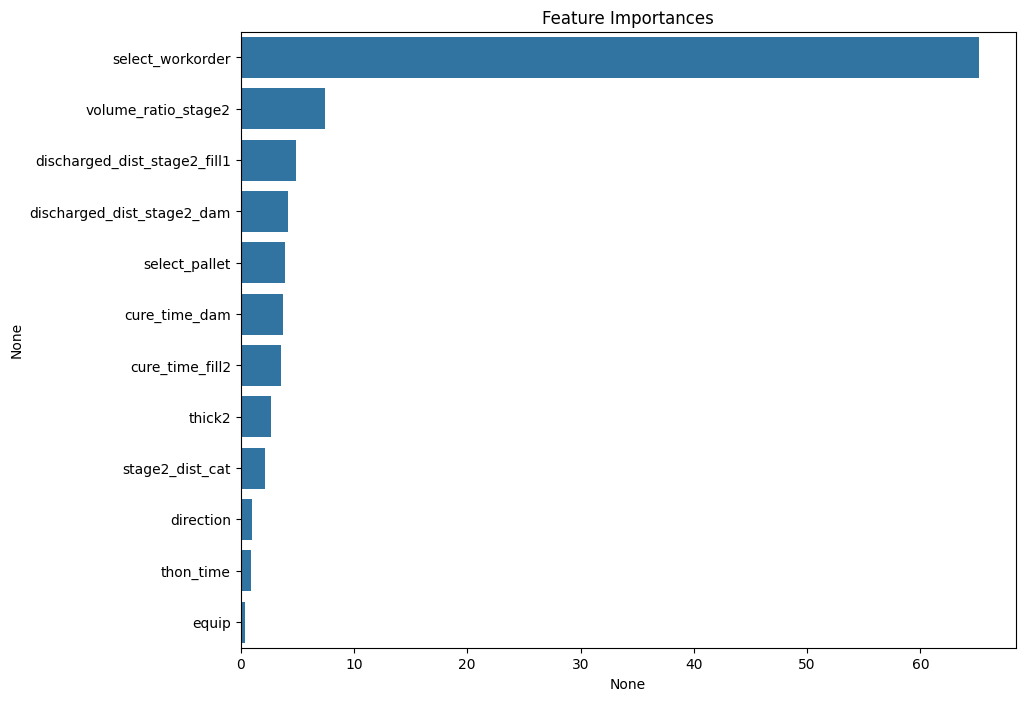

In [16]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [17]:
pred = stage2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  92  359]
 [ 437 7195]]

정확도: 0.9015
정밀도: 0.1739
재현율: 0.2040
F1: 0.1878


# Stage3

In [18]:
X_stage3 = df_stage3.drop(columns=['target'])
y_stage3 = df_stage3['target']

cat_features_indices_stage3 = ['select_pallet', 'stage3_dist_cat']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage3, y_stage3, test_size=0.2, random_state=42, stratify = y_stage3)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage3)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage3)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 05:49:33,737] A new study created in memory with name: no-name-a079bbe1-64c2-48d8-bb8b-323cd8b1dbd7
[I 2024-08-16 05:49:34,405] Trial 0 finished with value: 0.5624496110051868 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5624496110051868.
[I 2024-08-16 05:49:35,500] Trial 1 finished with value: 0.5623358691826624 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5624496110051868.
[I 2024-08-16

[I 2024-08-16 05:51:40,257] Trial 19 finished with value: 0.5637969860322218 and parameters: {'iterations': 978, 'depth': 9, 'learning_rate': 0.00428296276073061, 'l2_leaf_reg': 8.742774892012765, 'border_count': 131, 'random_strength': 8.506171326562402, 'bagging_temperature': 0.3976670151561788, 'od_type': 'Iter', 'od_wait': 10, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 4 with value: 0.5727425030556186.
[I 2024-08-16 05:51:45,671] Trial 20 finished with value: 0.5671477032415705 and parameters: {'iterations': 812, 'depth': 6, 'learning_rate': 0.025957244906898266, 'l2_leaf_reg': 6.976154426020404, 'border_count': 61, 'random_strength': 9.974698284812263, 'bagging_temperature': 0.15031435444774383, 'od_type': 'Iter', 'od_wait': 19, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 4 with value: 0.5727425030556186.
[I 2024-08-16 05:51:57,964] Trial 21 finished with value: 0.5664375653438792 and parameters: {'iterations': 871, 'depth': 8, 'learnin

[I 2024-08-16 05:53:56,643] Trial 38 finished with value: 0.5728995835222539 and parameters: {'iterations': 570, 'depth': 6, 'learning_rate': 0.024284527546615572, 'l2_leaf_reg': 6.61416312632965, 'border_count': 75, 'random_strength': 0.19905692275048326, 'bagging_temperature': 0.3302866936752913, 'od_type': 'Iter', 'od_wait': 38, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 22 with value: 0.5748772454997526.
[I 2024-08-16 05:54:02,263] Trial 39 finished with value: 0.5622443933136485 and parameters: {'iterations': 393, 'depth': 5, 'learning_rate': 0.023566183656254746, 'l2_leaf_reg': 6.836900003895182, 'border_count': 73, 'random_strength': 0.2673214117787812, 'bagging_temperature': 0.362007739945942, 'od_type': 'Iter', 'od_wait': 40, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 22 with value: 0.5748772454997526.
[I 2024-08-16 05:54:02,666] Trial 40 finished with value: 0.5628799030019267 and parameters: {'iterations': 940, 'depth': 6, 'lear

Best trial:
  Value: 0.5760485230223977
  Params: 
    iterations: 445
    depth: 6
    learning_rate: 0.0546903098103228
    l2_leaf_reg: 8.390289398900835
    border_count: 76
    random_strength: 0.03529331392605628
    bagging_temperature: 0.3273841786218997
    od_type: Iter
    od_wait: 45
    boosting_type: Ordered
    scale_pos_weight: 7


In [19]:
study.best_trial.params

{'iterations': 445,
 'depth': 6,
 'learning_rate': 0.0546903098103228,
 'l2_leaf_reg': 8.390289398900835,
 'border_count': 76,
 'random_strength': 0.03529331392605628,
 'bagging_temperature': 0.3273841786218997,
 'od_type': 'Iter',
 'od_wait': 45,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 7}

In [20]:
# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = study.best_trial.params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage3)

0:	learn: 0.6688219	total: 15.3ms	remaining: 6.78s
1:	learn: 0.6490766	total: 30.5ms	remaining: 6.76s
2:	learn: 0.6327347	total: 45.5ms	remaining: 6.7s
3:	learn: 0.6187579	total: 59.4ms	remaining: 6.55s
4:	learn: 0.6103580	total: 74.7ms	remaining: 6.57s
5:	learn: 0.6027496	total: 89.6ms	remaining: 6.56s
6:	learn: 0.5932371	total: 103ms	remaining: 6.46s
7:	learn: 0.5876067	total: 114ms	remaining: 6.24s
8:	learn: 0.5823656	total: 130ms	remaining: 6.28s
9:	learn: 0.5780441	total: 143ms	remaining: 6.21s
10:	learn: 0.5740673	total: 157ms	remaining: 6.19s
11:	learn: 0.5705445	total: 172ms	remaining: 6.19s
12:	learn: 0.5654821	total: 187ms	remaining: 6.22s
13:	learn: 0.5626901	total: 202ms	remaining: 6.22s
14:	learn: 0.5602862	total: 217ms	remaining: 6.22s
15:	learn: 0.5567568	total: 233ms	remaining: 6.24s
16:	learn: 0.5538455	total: 248ms	remaining: 6.24s
17:	learn: 0.5522315	total: 262ms	remaining: 6.21s
18:	learn: 0.5507541	total: 277ms	remaining: 6.21s
19:	learn: 0.5494473	total: 292ms	re

162:	learn: 0.5232627	total: 2.49s	remaining: 4.3s
163:	learn: 0.5232618	total: 2.5s	remaining: 4.29s
164:	learn: 0.5232610	total: 2.52s	remaining: 4.27s
165:	learn: 0.5232512	total: 2.53s	remaining: 4.25s
166:	learn: 0.5232487	total: 2.55s	remaining: 4.24s
167:	learn: 0.5232480	total: 2.56s	remaining: 4.22s
168:	learn: 0.5232084	total: 2.58s	remaining: 4.21s
169:	learn: 0.5231582	total: 2.59s	remaining: 4.19s
170:	learn: 0.5231427	total: 2.61s	remaining: 4.18s
171:	learn: 0.5230849	total: 2.62s	remaining: 4.16s
172:	learn: 0.5230841	total: 2.64s	remaining: 4.14s
173:	learn: 0.5230826	total: 2.65s	remaining: 4.13s
174:	learn: 0.5230823	total: 2.67s	remaining: 4.11s
175:	learn: 0.5230745	total: 2.68s	remaining: 4.1s
176:	learn: 0.5230504	total: 2.7s	remaining: 4.08s
177:	learn: 0.5230394	total: 2.71s	remaining: 4.07s
178:	learn: 0.5230348	total: 2.73s	remaining: 4.05s
179:	learn: 0.5230343	total: 2.74s	remaining: 4.04s
180:	learn: 0.5229954	total: 2.76s	remaining: 4.02s
181:	learn: 0.52

324:	learn: 0.5224976	total: 4.93s	remaining: 1.82s
325:	learn: 0.5224975	total: 4.94s	remaining: 1.8s
326:	learn: 0.5224808	total: 4.96s	remaining: 1.79s
327:	learn: 0.5224754	total: 4.97s	remaining: 1.77s
328:	learn: 0.5224537	total: 4.99s	remaining: 1.76s
329:	learn: 0.5224531	total: 5s	remaining: 1.74s
330:	learn: 0.5224393	total: 5.02s	remaining: 1.73s
331:	learn: 0.5224388	total: 5.03s	remaining: 1.71s
332:	learn: 0.5224263	total: 5.05s	remaining: 1.7s
333:	learn: 0.5224259	total: 5.06s	remaining: 1.68s
334:	learn: 0.5224255	total: 5.08s	remaining: 1.67s
335:	learn: 0.5224251	total: 5.09s	remaining: 1.65s
336:	learn: 0.5224247	total: 5.1s	remaining: 1.64s
337:	learn: 0.5224134	total: 5.12s	remaining: 1.62s
338:	learn: 0.5224130	total: 5.13s	remaining: 1.6s
339:	learn: 0.5224126	total: 5.15s	remaining: 1.59s
340:	learn: 0.5224123	total: 5.16s	remaining: 1.57s
341:	learn: 0.5224121	total: 5.17s	remaining: 1.56s
342:	learn: 0.5224118	total: 5.19s	remaining: 1.54s
343:	learn: 0.52241

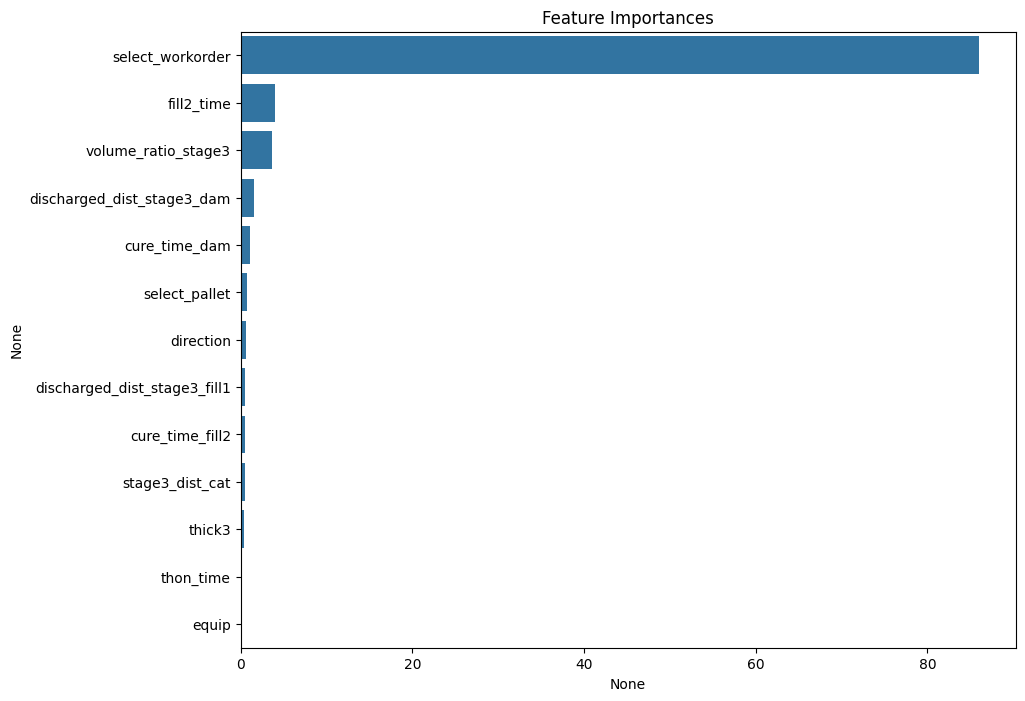

In [21]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage3_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [22]:
pred = stage3_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 159  292]
 [ 812 6820]]

정확도: 0.8634
정밀도: 0.1637
재현율: 0.3525
F1: 0.2236


# AutoClave

In [23]:
X_AutoClave = df_autoclave.drop(columns=['target'])
y_AutoClave = df_autoclave['target']

cat_features_indices_autoclave = ['select_pallet', 'chamber_temp']

X_train, X_valid, y_train, y_valid = train_test_split(X_AutoClave, y_AutoClave, test_size=0.2, random_state=42, stratify = y_AutoClave)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_autoclave)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_autoclave)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-16 05:54:27,778] A new study created in memory with name: no-name-a23e46d0-31b1-478f-97cb-dc44cada38a8
[I 2024-08-16 05:54:29,069] Trial 0 finished with value: 0.5614359012783152 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5614359012783152.
[I 2024-08-16 05:54:31,939] Trial 1 finished with value: 0.5618864180801898 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 1 with value: 0.5618864180801898.
[I 2024-08-16

[I 2024-08-16 05:55:45,734] Trial 19 finished with value: 0.5703132874461143 and parameters: {'iterations': 684, 'depth': 9, 'learning_rate': 0.42763408045360407, 'l2_leaf_reg': 5.757532834074908, 'border_count': 79, 'random_strength': 5.709773748221135, 'bagging_temperature': 0.5172881815903392, 'od_type': 'IncToDec', 'od_wait': 16, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 4 with value: 0.5703478239926603.
[I 2024-08-16 05:55:48,086] Trial 20 finished with value: 0.5622175438436459 and parameters: {'iterations': 671, 'depth': 10, 'learning_rate': 0.41508042807308376, 'l2_leaf_reg': 6.480410419791919, 'border_count': 77, 'random_strength': 4.060316032518396, 'bagging_temperature': 0.4856499040487336, 'od_type': 'Iter', 'od_wait': 50, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 4 with value: 0.5703478239926603.
[I 2024-08-16 05:55:50,051] Trial 21 finished with value: 0.5556716387001206 and parameters: {'iterations': 782, 'depth': 9, 'learn

[I 2024-08-16 05:56:52,011] Trial 38 finished with value: 0.5650177729313299 and parameters: {'iterations': 803, 'depth': 6, 'learning_rate': 0.12604135911907877, 'l2_leaf_reg': 8.006069052401166, 'border_count': 98, 'random_strength': 2.1794534646181503, 'bagging_temperature': 0.2560036567234012, 'od_type': 'IncToDec', 'od_wait': 31, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 24 with value: 0.57139853185947.
[I 2024-08-16 05:56:56,405] Trial 39 finished with value: 0.561684583273708 and parameters: {'iterations': 393, 'depth': 10, 'learning_rate': 0.040690231979336404, 'l2_leaf_reg': 1.8977852489015472, 'border_count': 74, 'random_strength': 5.68530117152778, 'bagging_temperature': 0.6304039309034717, 'od_type': 'Iter', 'od_wait': 27, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 24 with value: 0.57139853185947.
[I 2024-08-16 05:56:58,056] Trial 40 finished with value: 0.5615837681235052 and parameters: {'iterations': 882, 'depth': 9, 'learn

Best trial:
  Value: 0.57139853185947
  Params: 
    iterations: 891
    depth: 10
    learning_rate: 0.21731939976796613
    l2_leaf_reg: 8.702862999223036
    border_count: 51
    random_strength: 6.633076645300532
    bagging_temperature: 0.3753171592349781
    od_type: IncToDec
    od_wait: 15
    boosting_type: Ordered
    scale_pos_weight: 7


In [24]:
study.best_trial.params

{'iterations': 891,
 'depth': 10,
 'learning_rate': 0.21731939976796613,
 'l2_leaf_reg': 8.702862999223036,
 'border_count': 51,
 'random_strength': 6.633076645300532,
 'bagging_temperature': 0.3753171592349781,
 'od_type': 'IncToDec',
 'od_wait': 15,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 7}

In [25]:
# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(random_state = 42, **AutoClave_best_params)
AutoClave_best_model.fit(X_train, y_train, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6359579	total: 39.4ms	remaining: 35.1s
1:	learn: 0.6130139	total: 60.3ms	remaining: 26.8s
2:	learn: 0.6008648	total: 70.4ms	remaining: 20.8s
3:	learn: 0.5820876	total: 91ms	remaining: 20.2s
4:	learn: 0.5711492	total: 106ms	remaining: 18.9s
5:	learn: 0.5685036	total: 125ms	remaining: 18.4s
6:	learn: 0.5522933	total: 169ms	remaining: 21.3s
7:	learn: 0.5428648	total: 190ms	remaining: 21s
8:	learn: 0.5388149	total: 206ms	remaining: 20.2s
9:	learn: 0.5385692	total: 217ms	remaining: 19.1s
10:	learn: 0.5363009	total: 249ms	remaining: 20s
11:	learn: 0.5356817	total: 282ms	remaining: 20.6s
12:	learn: 0.5353890	total: 297ms	remaining: 20.1s
13:	learn: 0.5353174	total: 315ms	remaining: 19.7s
14:	learn: 0.5353074	total: 330ms	remaining: 19.3s
15:	learn: 0.5353026	total: 340ms	remaining: 18.6s
16:	learn: 0.5352078	total: 356ms	remaining: 18.3s
17:	learn: 0.5351480	total: 375ms	remaining: 18.2s
18:	learn: 0.5342321	total: 396ms	remaining: 18.2s
19:	learn: 0.5338870	total: 420ms	remaining

161:	learn: 0.5220402	total: 4.75s	remaining: 21.4s
162:	learn: 0.5220266	total: 4.8s	remaining: 21.5s
163:	learn: 0.5220258	total: 4.83s	remaining: 21.4s
164:	learn: 0.5220251	total: 4.88s	remaining: 21.5s
165:	learn: 0.5220251	total: 4.9s	remaining: 21.4s
166:	learn: 0.5220244	total: 4.93s	remaining: 21.4s
167:	learn: 0.5220243	total: 4.95s	remaining: 21.3s
168:	learn: 0.5220243	total: 4.97s	remaining: 21.3s
169:	learn: 0.5220237	total: 5s	remaining: 21.2s
170:	learn: 0.5220228	total: 5.03s	remaining: 21.2s
171:	learn: 0.5220228	total: 5.06s	remaining: 21.1s
172:	learn: 0.5220228	total: 5.08s	remaining: 21.1s
173:	learn: 0.5220217	total: 5.13s	remaining: 21.1s
174:	learn: 0.5220212	total: 5.17s	remaining: 21.1s
175:	learn: 0.5220207	total: 5.2s	remaining: 21.1s
176:	learn: 0.5220207	total: 5.24s	remaining: 21.1s
177:	learn: 0.5220206	total: 5.26s	remaining: 21.1s
178:	learn: 0.5220206	total: 5.29s	remaining: 21s
179:	learn: 0.5220206	total: 5.32s	remaining: 21s
180:	learn: 0.5220200	

322:	learn: 0.5213429	total: 10s	remaining: 17.7s
323:	learn: 0.5213428	total: 10.1s	remaining: 17.7s
324:	learn: 0.5213428	total: 10.1s	remaining: 17.6s
325:	learn: 0.5213427	total: 10.1s	remaining: 17.6s
326:	learn: 0.5213411	total: 10.2s	remaining: 17.6s
327:	learn: 0.5213398	total: 10.2s	remaining: 17.5s
328:	learn: 0.5213143	total: 10.3s	remaining: 17.5s
329:	learn: 0.5213130	total: 10.3s	remaining: 17.5s
330:	learn: 0.5213129	total: 10.3s	remaining: 17.5s
331:	learn: 0.5213119	total: 10.4s	remaining: 17.5s
332:	learn: 0.5212627	total: 10.4s	remaining: 17.5s
333:	learn: 0.5212620	total: 10.5s	remaining: 17.5s
334:	learn: 0.5212619	total: 10.5s	remaining: 17.4s
335:	learn: 0.5212615	total: 10.6s	remaining: 17.4s
336:	learn: 0.5212614	total: 10.6s	remaining: 17.4s
337:	learn: 0.5212614	total: 10.6s	remaining: 17.3s
338:	learn: 0.5212614	total: 10.6s	remaining: 17.3s
339:	learn: 0.5212596	total: 10.7s	remaining: 17.3s
340:	learn: 0.5212596	total: 10.7s	remaining: 17.2s
341:	learn: 0.

488:	learn: 0.5210003	total: 15.4s	remaining: 12.7s
489:	learn: 0.5210003	total: 15.5s	remaining: 12.7s
490:	learn: 0.5210002	total: 15.5s	remaining: 12.6s
491:	learn: 0.5210002	total: 15.5s	remaining: 12.6s
492:	learn: 0.5209988	total: 15.6s	remaining: 12.6s
493:	learn: 0.5209988	total: 15.6s	remaining: 12.5s
494:	learn: 0.5209984	total: 15.6s	remaining: 12.5s
495:	learn: 0.5209984	total: 15.6s	remaining: 12.5s
496:	learn: 0.5209983	total: 15.7s	remaining: 12.4s
497:	learn: 0.5209983	total: 15.7s	remaining: 12.4s
498:	learn: 0.5209983	total: 15.8s	remaining: 12.4s
499:	learn: 0.5209983	total: 15.8s	remaining: 12.3s
500:	learn: 0.5209970	total: 15.8s	remaining: 12.3s
501:	learn: 0.5209970	total: 15.9s	remaining: 12.3s
502:	learn: 0.5209966	total: 15.9s	remaining: 12.3s
503:	learn: 0.5209965	total: 15.9s	remaining: 12.2s
504:	learn: 0.5209965	total: 16s	remaining: 12.2s
505:	learn: 0.5209955	total: 16s	remaining: 12.2s
506:	learn: 0.5209955	total: 16s	remaining: 12.1s
507:	learn: 0.5209

653:	learn: 0.5206474	total: 20.5s	remaining: 7.42s
654:	learn: 0.5206474	total: 20.5s	remaining: 7.39s
655:	learn: 0.5206474	total: 20.5s	remaining: 7.36s
656:	learn: 0.5206474	total: 20.6s	remaining: 7.33s
657:	learn: 0.5206438	total: 20.6s	remaining: 7.3s
658:	learn: 0.5206438	total: 20.7s	remaining: 7.27s
659:	learn: 0.5206438	total: 20.7s	remaining: 7.24s
660:	learn: 0.5206437	total: 20.7s	remaining: 7.21s
661:	learn: 0.5206437	total: 20.7s	remaining: 7.17s
662:	learn: 0.5206437	total: 20.8s	remaining: 7.14s
663:	learn: 0.5206436	total: 20.8s	remaining: 7.11s
664:	learn: 0.5206435	total: 20.8s	remaining: 7.08s
665:	learn: 0.5206435	total: 20.8s	remaining: 7.04s
666:	learn: 0.5206435	total: 20.9s	remaining: 7.01s
667:	learn: 0.5206435	total: 20.9s	remaining: 6.98s
668:	learn: 0.5206425	total: 21s	remaining: 6.95s
669:	learn: 0.5206424	total: 21s	remaining: 6.92s
670:	learn: 0.5206424	total: 21s	remaining: 6.89s
671:	learn: 0.5206424	total: 21s	remaining: 6.86s
672:	learn: 0.5206416

812:	learn: 0.5205782	total: 25.3s	remaining: 2.42s
813:	learn: 0.5205782	total: 25.3s	remaining: 2.39s
814:	learn: 0.5205782	total: 25.3s	remaining: 2.36s
815:	learn: 0.5205782	total: 25.4s	remaining: 2.33s
816:	learn: 0.5205782	total: 25.4s	remaining: 2.3s
817:	learn: 0.5205782	total: 25.4s	remaining: 2.27s
818:	learn: 0.5205782	total: 25.5s	remaining: 2.24s
819:	learn: 0.5205781	total: 25.5s	remaining: 2.21s
820:	learn: 0.5205766	total: 25.6s	remaining: 2.18s
821:	learn: 0.5205765	total: 25.6s	remaining: 2.15s
822:	learn: 0.5205765	total: 25.6s	remaining: 2.11s
823:	learn: 0.5205765	total: 25.6s	remaining: 2.08s
824:	learn: 0.5205765	total: 25.7s	remaining: 2.05s
825:	learn: 0.5205765	total: 25.7s	remaining: 2.02s
826:	learn: 0.5205765	total: 25.7s	remaining: 1.99s
827:	learn: 0.5205765	total: 25.8s	remaining: 1.96s
828:	learn: 0.5205765	total: 25.8s	remaining: 1.93s
829:	learn: 0.5205765	total: 25.8s	remaining: 1.9s
830:	learn: 0.5205765	total: 25.8s	remaining: 1.86s
831:	learn: 0.

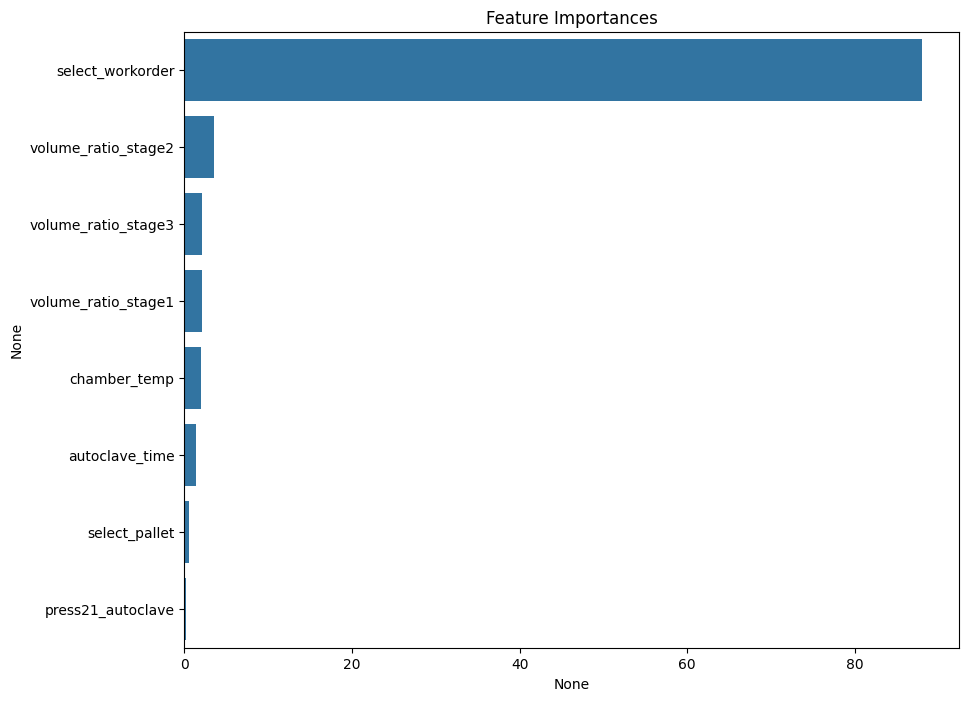

In [26]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(AutoClave_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [27]:
pred = AutoClave_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 139  312]
 [ 752 6880]]

정확도: 0.8684
정밀도: 0.1560
재현율: 0.3082
F1: 0.2072


# 민감성

In [28]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = stage1_best_params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_stage1, y_stage1, cat_features=cat_features_indices_stage1)

# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = stage2_best_params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_stage2, y_stage2, cat_features=cat_features_indices_stage2)

# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = stage3_best_params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_stage3, y_stage3, cat_features=cat_features_indices_stage3)

# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = AutoClave_best_params
AutoClave_best_model = CatBoostClassifier(random_state = 42, **AutoClave_best_params)
AutoClave_best_model.fit(X_AutoClave, y_AutoClave, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6274098	total: 27.9ms	remaining: 19.9s
1:	learn: 0.5687382	total: 52.6ms	remaining: 18.8s
2:	learn: 0.5485789	total: 72.8ms	remaining: 17.3s
3:	learn: 0.5400034	total: 94.2ms	remaining: 16.7s
4:	learn: 0.5341300	total: 112ms	remaining: 15.9s
5:	learn: 0.5312654	total: 128ms	remaining: 15.2s
6:	learn: 0.5260758	total: 145ms	remaining: 14.7s
7:	learn: 0.5229527	total: 160ms	remaining: 14.2s
8:	learn: 0.5205783	total: 178ms	remaining: 14s
9:	learn: 0.5157882	total: 194ms	remaining: 13.7s
10:	learn: 0.5142861	total: 212ms	remaining: 13.6s
11:	learn: 0.5131327	total: 232ms	remaining: 13.6s
12:	learn: 0.5129624	total: 248ms	remaining: 13.4s
13:	learn: 0.5128197	total: 266ms	remaining: 13.3s
14:	learn: 0.5122820	total: 285ms	remaining: 13.3s
15:	learn: 0.5122707	total: 301ms	remaining: 13.1s
16:	learn: 0.5122304	total: 316ms	remaining: 13s
17:	learn: 0.5118513	total: 333ms	remaining: 12.9s
18:	learn: 0.5115233	total: 349ms	remaining: 12.8s
19:	learn: 0.5115191	total: 361ms	remaini

162:	learn: 0.5046389	total: 2.71s	remaining: 9.18s
163:	learn: 0.5045852	total: 2.73s	remaining: 9.16s
164:	learn: 0.5045637	total: 2.74s	remaining: 9.14s
165:	learn: 0.5045459	total: 2.76s	remaining: 9.13s
166:	learn: 0.5045453	total: 2.77s	remaining: 9.11s
167:	learn: 0.5045453	total: 2.79s	remaining: 9.08s
168:	learn: 0.5045406	total: 2.8s	remaining: 9.06s
169:	learn: 0.5045406	total: 2.82s	remaining: 9.04s
170:	learn: 0.5045387	total: 2.83s	remaining: 9.02s
171:	learn: 0.5045311	total: 2.85s	remaining: 9s
172:	learn: 0.5045292	total: 2.87s	remaining: 8.98s
173:	learn: 0.5045273	total: 2.88s	remaining: 8.97s
174:	learn: 0.5045152	total: 2.9s	remaining: 8.95s
175:	learn: 0.5045138	total: 2.92s	remaining: 8.93s
176:	learn: 0.5045138	total: 2.93s	remaining: 8.91s
177:	learn: 0.5045138	total: 2.94s	remaining: 8.88s
178:	learn: 0.5045107	total: 2.96s	remaining: 8.86s
179:	learn: 0.5045043	total: 2.97s	remaining: 8.84s
180:	learn: 0.5045032	total: 2.99s	remaining: 8.82s
181:	learn: 0.504

324:	learn: 0.5040737	total: 5.13s	remaining: 6.16s
325:	learn: 0.5040721	total: 5.14s	remaining: 6.14s
326:	learn: 0.5040721	total: 5.16s	remaining: 6.12s
327:	learn: 0.5040721	total: 5.17s	remaining: 6.1s
328:	learn: 0.5040721	total: 5.19s	remaining: 6.09s
329:	learn: 0.5040721	total: 5.2s	remaining: 6.07s
330:	learn: 0.5040696	total: 5.22s	remaining: 6.05s
331:	learn: 0.5040696	total: 5.23s	remaining: 6.04s
332:	learn: 0.5040696	total: 5.25s	remaining: 6.02s
333:	learn: 0.5040667	total: 5.26s	remaining: 6s
334:	learn: 0.5040667	total: 5.27s	remaining: 5.98s
335:	learn: 0.5040602	total: 5.29s	remaining: 5.97s
336:	learn: 0.5040602	total: 5.3s	remaining: 5.95s
337:	learn: 0.5040602	total: 5.32s	remaining: 5.93s
338:	learn: 0.5040601	total: 5.33s	remaining: 5.91s
339:	learn: 0.5040601	total: 5.35s	remaining: 5.9s
340:	learn: 0.5040601	total: 5.36s	remaining: 5.88s
341:	learn: 0.5040601	total: 5.37s	remaining: 5.86s
342:	learn: 0.5040589	total: 5.39s	remaining: 5.85s
343:	learn: 0.50405

483:	learn: 0.5038536	total: 7.41s	remaining: 3.54s
484:	learn: 0.5038535	total: 7.43s	remaining: 3.52s
485:	learn: 0.5038534	total: 7.44s	remaining: 3.51s
486:	learn: 0.5038534	total: 7.46s	remaining: 3.49s
487:	learn: 0.5038534	total: 7.47s	remaining: 3.47s
488:	learn: 0.5038531	total: 7.48s	remaining: 3.46s
489:	learn: 0.5038531	total: 7.5s	remaining: 3.44s
490:	learn: 0.5038531	total: 7.51s	remaining: 3.43s
491:	learn: 0.5038531	total: 7.53s	remaining: 3.41s
492:	learn: 0.5038526	total: 7.54s	remaining: 3.4s
493:	learn: 0.5038523	total: 7.55s	remaining: 3.38s
494:	learn: 0.5038520	total: 7.57s	remaining: 3.36s
495:	learn: 0.5038520	total: 7.58s	remaining: 3.35s
496:	learn: 0.5038520	total: 7.6s	remaining: 3.33s
497:	learn: 0.5038520	total: 7.61s	remaining: 3.32s
498:	learn: 0.5038520	total: 7.63s	remaining: 3.3s
499:	learn: 0.5038519	total: 7.64s	remaining: 3.29s
500:	learn: 0.5038519	total: 7.65s	remaining: 3.27s
501:	learn: 0.5038519	total: 7.67s	remaining: 3.25s
502:	learn: 0.50

646:	learn: 0.5036674	total: 9.71s	remaining: 1.02s
647:	learn: 0.5036674	total: 9.72s	remaining: 1s
648:	learn: 0.5036667	total: 9.74s	remaining: 990ms
649:	learn: 0.5036664	total: 9.75s	remaining: 975ms
650:	learn: 0.5036664	total: 9.77s	remaining: 960ms
651:	learn: 0.5036663	total: 9.78s	remaining: 945ms
652:	learn: 0.5036663	total: 9.79s	remaining: 930ms
653:	learn: 0.5036663	total: 9.81s	remaining: 915ms
654:	learn: 0.5036656	total: 9.82s	remaining: 900ms
655:	learn: 0.5036655	total: 9.84s	remaining: 885ms
656:	learn: 0.5036653	total: 9.85s	remaining: 870ms
657:	learn: 0.5036647	total: 9.87s	remaining: 855ms
658:	learn: 0.5036642	total: 9.88s	remaining: 840ms
659:	learn: 0.5036638	total: 9.9s	remaining: 825ms
660:	learn: 0.5036638	total: 9.91s	remaining: 810ms
661:	learn: 0.5036638	total: 9.93s	remaining: 795ms
662:	learn: 0.5036638	total: 9.94s	remaining: 780ms
663:	learn: 0.5036637	total: 9.96s	remaining: 765ms
664:	learn: 0.5036628	total: 9.97s	remaining: 750ms
665:	learn: 0.50

92:	learn: 0.5062269	total: 1.05s	remaining: 3.05s
93:	learn: 0.5062269	total: 1.06s	remaining: 3.02s
94:	learn: 0.5061924	total: 1.07s	remaining: 3.01s
95:	learn: 0.5061820	total: 1.08s	remaining: 3s
96:	learn: 0.5059860	total: 1.09s	remaining: 2.99s
97:	learn: 0.5059857	total: 1.1s	remaining: 2.97s
98:	learn: 0.5057841	total: 1.12s	remaining: 2.97s
99:	learn: 0.5055437	total: 1.13s	remaining: 2.96s
100:	learn: 0.5052896	total: 1.15s	remaining: 2.96s
101:	learn: 0.5051449	total: 1.16s	remaining: 2.96s
102:	learn: 0.5051250	total: 1.17s	remaining: 2.95s
103:	learn: 0.5051099	total: 1.18s	remaining: 2.94s
104:	learn: 0.5049667	total: 1.2s	remaining: 2.93s
105:	learn: 0.5048663	total: 1.21s	remaining: 2.92s
106:	learn: 0.5042625	total: 1.22s	remaining: 2.91s
107:	learn: 0.5040351	total: 1.24s	remaining: 2.91s
108:	learn: 0.5036851	total: 1.25s	remaining: 2.91s
109:	learn: 0.5035381	total: 1.27s	remaining: 2.9s
110:	learn: 0.5034354	total: 1.28s	remaining: 2.89s
111:	learn: 0.5033825	tota

252:	learn: 0.4787215	total: 3.33s	remaining: 1.43s
253:	learn: 0.4786356	total: 3.34s	remaining: 1.42s
254:	learn: 0.4785450	total: 3.36s	remaining: 1.41s
255:	learn: 0.4785286	total: 3.37s	remaining: 1.4s
256:	learn: 0.4784223	total: 3.39s	remaining: 1.38s
257:	learn: 0.4783171	total: 3.4s	remaining: 1.37s
258:	learn: 0.4781396	total: 3.42s	remaining: 1.36s
259:	learn: 0.4780760	total: 3.43s	remaining: 1.35s
260:	learn: 0.4780283	total: 3.44s	remaining: 1.33s
261:	learn: 0.4779477	total: 3.46s	remaining: 1.32s
262:	learn: 0.4779083	total: 3.47s	remaining: 1.31s
263:	learn: 0.4778154	total: 3.49s	remaining: 1.29s
264:	learn: 0.4777256	total: 3.5s	remaining: 1.28s
265:	learn: 0.4776378	total: 3.52s	remaining: 1.27s
266:	learn: 0.4774597	total: 3.54s	remaining: 1.26s
267:	learn: 0.4774348	total: 3.55s	remaining: 1.25s
268:	learn: 0.4773601	total: 3.57s	remaining: 1.23s
269:	learn: 0.4772558	total: 3.59s	remaining: 1.22s
270:	learn: 0.4771003	total: 3.6s	remaining: 1.21s
271:	learn: 0.47

52:	learn: 0.5322185	total: 844ms	remaining: 6.24s
53:	learn: 0.5320994	total: 861ms	remaining: 6.23s
54:	learn: 0.5320059	total: 877ms	remaining: 6.22s
55:	learn: 0.5318795	total: 894ms	remaining: 6.21s
56:	learn: 0.5316475	total: 911ms	remaining: 6.2s
57:	learn: 0.5315501	total: 927ms	remaining: 6.18s
58:	learn: 0.5314123	total: 946ms	remaining: 6.19s
59:	learn: 0.5313116	total: 963ms	remaining: 6.18s
60:	learn: 0.5311664	total: 980ms	remaining: 6.17s
61:	learn: 0.5309303	total: 998ms	remaining: 6.16s
62:	learn: 0.5308433	total: 1.01s	remaining: 6.16s
63:	learn: 0.5304806	total: 1.03s	remaining: 6.15s
64:	learn: 0.5303323	total: 1.05s	remaining: 6.14s
65:	learn: 0.5302536	total: 1.07s	remaining: 6.13s
66:	learn: 0.5301682	total: 1.08s	remaining: 6.12s
67:	learn: 0.5300989	total: 1.1s	remaining: 6.11s
68:	learn: 0.5300003	total: 1.12s	remaining: 6.09s
69:	learn: 0.5299128	total: 1.14s	remaining: 6.08s
70:	learn: 0.5298567	total: 1.15s	remaining: 6.08s
71:	learn: 0.5296050	total: 1.17s

216:	learn: 0.5257194	total: 3.57s	remaining: 3.75s
217:	learn: 0.5256917	total: 3.59s	remaining: 3.74s
218:	learn: 0.5256816	total: 3.6s	remaining: 3.72s
219:	learn: 0.5256801	total: 3.62s	remaining: 3.7s
220:	learn: 0.5256581	total: 3.64s	remaining: 3.69s
221:	learn: 0.5256562	total: 3.65s	remaining: 3.67s
222:	learn: 0.5256537	total: 3.67s	remaining: 3.65s
223:	learn: 0.5256522	total: 3.69s	remaining: 3.64s
224:	learn: 0.5256491	total: 3.7s	remaining: 3.62s
225:	learn: 0.5256464	total: 3.72s	remaining: 3.6s
226:	learn: 0.5256450	total: 3.74s	remaining: 3.59s
227:	learn: 0.5256424	total: 3.75s	remaining: 3.57s
228:	learn: 0.5256397	total: 3.77s	remaining: 3.56s
229:	learn: 0.5256207	total: 3.79s	remaining: 3.54s
230:	learn: 0.5256057	total: 3.81s	remaining: 3.53s
231:	learn: 0.5256056	total: 3.82s	remaining: 3.51s
232:	learn: 0.5255989	total: 3.83s	remaining: 3.49s
233:	learn: 0.5255979	total: 3.85s	remaining: 3.47s
234:	learn: 0.5255963	total: 3.87s	remaining: 3.45s
235:	learn: 0.52

381:	learn: 0.5248012	total: 6.29s	remaining: 1.04s
382:	learn: 0.5248006	total: 6.31s	remaining: 1.02s
383:	learn: 0.5248002	total: 6.33s	remaining: 1s
384:	learn: 0.5247999	total: 6.34s	remaining: 989ms
385:	learn: 0.5247987	total: 6.36s	remaining: 972ms
386:	learn: 0.5247961	total: 6.37s	remaining: 955ms
387:	learn: 0.5247949	total: 6.39s	remaining: 939ms
388:	learn: 0.5246390	total: 6.41s	remaining: 923ms
389:	learn: 0.5246380	total: 6.42s	remaining: 906ms
390:	learn: 0.5246244	total: 6.44s	remaining: 889ms
391:	learn: 0.5246190	total: 6.46s	remaining: 873ms
392:	learn: 0.5246181	total: 6.47s	remaining: 856ms
393:	learn: 0.5246160	total: 6.49s	remaining: 840ms
394:	learn: 0.5245839	total: 6.5s	remaining: 823ms
395:	learn: 0.5245831	total: 6.52s	remaining: 807ms
396:	learn: 0.5245824	total: 6.53s	remaining: 790ms
397:	learn: 0.5245817	total: 6.55s	remaining: 773ms
398:	learn: 0.5245813	total: 6.56s	remaining: 757ms
399:	learn: 0.5245807	total: 6.58s	remaining: 740ms
400:	learn: 0.52

97:	learn: 0.5242136	total: 2.95s	remaining: 23.9s
98:	learn: 0.5242076	total: 2.99s	remaining: 23.9s
99:	learn: 0.5241549	total: 3.04s	remaining: 24.1s
100:	learn: 0.5241544	total: 3.06s	remaining: 24s
101:	learn: 0.5241442	total: 3.12s	remaining: 24.1s
102:	learn: 0.5241394	total: 3.17s	remaining: 24.2s
103:	learn: 0.5241347	total: 3.21s	remaining: 24.3s
104:	learn: 0.5241025	total: 3.27s	remaining: 24.4s
105:	learn: 0.5240963	total: 3.32s	remaining: 24.6s
106:	learn: 0.5240921	total: 3.37s	remaining: 24.7s
107:	learn: 0.5240892	total: 3.43s	remaining: 24.8s
108:	learn: 0.5240052	total: 3.48s	remaining: 25s
109:	learn: 0.5239233	total: 3.53s	remaining: 25.1s
110:	learn: 0.5239178	total: 3.56s	remaining: 25s
111:	learn: 0.5238738	total: 3.61s	remaining: 25.1s
112:	learn: 0.5238681	total: 3.66s	remaining: 25.2s
113:	learn: 0.5238656	total: 3.71s	remaining: 25.3s
114:	learn: 0.5238247	total: 3.76s	remaining: 25.4s
115:	learn: 0.5237514	total: 3.82s	remaining: 25.5s
116:	learn: 0.5237481

258:	learn: 0.5203670	total: 9.73s	remaining: 23.7s
259:	learn: 0.5203656	total: 9.75s	remaining: 23.7s
260:	learn: 0.5203653	total: 9.78s	remaining: 23.6s
261:	learn: 0.5203649	total: 9.8s	remaining: 23.5s
262:	learn: 0.5203647	total: 9.82s	remaining: 23.5s
263:	learn: 0.5203019	total: 9.88s	remaining: 23.5s
264:	learn: 0.5203012	total: 9.92s	remaining: 23.4s
265:	learn: 0.5203011	total: 9.95s	remaining: 23.4s
266:	learn: 0.5203011	total: 9.97s	remaining: 23.3s
267:	learn: 0.5203011	total: 10s	remaining: 23.2s
268:	learn: 0.5202993	total: 10s	remaining: 23.2s
269:	learn: 0.5202985	total: 10.1s	remaining: 23.2s
270:	learn: 0.5202971	total: 10.1s	remaining: 23.1s
271:	learn: 0.5202790	total: 10.1s	remaining: 23s
272:	learn: 0.5202790	total: 10.1s	remaining: 22.9s
273:	learn: 0.5202789	total: 10.2s	remaining: 22.9s
274:	learn: 0.5202737	total: 10.2s	remaining: 22.9s
275:	learn: 0.5202734	total: 10.2s	remaining: 22.8s
276:	learn: 0.5202729	total: 10.3s	remaining: 22.7s
277:	learn: 0.52003

417:	learn: 0.5193873	total: 15.2s	remaining: 17.2s
418:	learn: 0.5193872	total: 15.2s	remaining: 17.1s
419:	learn: 0.5193871	total: 15.2s	remaining: 17.1s
420:	learn: 0.5193775	total: 15.3s	remaining: 17.1s
421:	learn: 0.5193771	total: 15.3s	remaining: 17s
422:	learn: 0.5193771	total: 15.3s	remaining: 17s
423:	learn: 0.5193764	total: 15.4s	remaining: 16.9s
424:	learn: 0.5193453	total: 15.4s	remaining: 16.9s
425:	learn: 0.5193448	total: 15.4s	remaining: 16.8s
426:	learn: 0.5193448	total: 15.5s	remaining: 16.8s
427:	learn: 0.5193443	total: 15.5s	remaining: 16.8s
428:	learn: 0.5193443	total: 15.5s	remaining: 16.7s
429:	learn: 0.5193443	total: 15.5s	remaining: 16.7s
430:	learn: 0.5193443	total: 15.6s	remaining: 16.6s
431:	learn: 0.5193443	total: 15.6s	remaining: 16.6s
432:	learn: 0.5193441	total: 15.7s	remaining: 16.6s
433:	learn: 0.5193437	total: 15.7s	remaining: 16.5s
434:	learn: 0.5193437	total: 15.8s	remaining: 16.5s
435:	learn: 0.5193436	total: 15.8s	remaining: 16.5s
436:	learn: 0.51

581:	learn: 0.5186292	total: 20.8s	remaining: 11s
582:	learn: 0.5186282	total: 20.8s	remaining: 11s
583:	learn: 0.5186230	total: 20.9s	remaining: 11s
584:	learn: 0.5186230	total: 20.9s	remaining: 10.9s
585:	learn: 0.5186229	total: 20.9s	remaining: 10.9s
586:	learn: 0.5186229	total: 20.9s	remaining: 10.8s
587:	learn: 0.5186229	total: 21s	remaining: 10.8s
588:	learn: 0.5186229	total: 21s	remaining: 10.8s
589:	learn: 0.5186225	total: 21s	remaining: 10.7s
590:	learn: 0.5186223	total: 21s	remaining: 10.7s
591:	learn: 0.5186222	total: 21.1s	remaining: 10.6s
592:	learn: 0.5186222	total: 21.1s	remaining: 10.6s
593:	learn: 0.5186222	total: 21.1s	remaining: 10.6s
594:	learn: 0.5186213	total: 21.2s	remaining: 10.5s
595:	learn: 0.5186165	total: 21.2s	remaining: 10.5s
596:	learn: 0.5186161	total: 21.3s	remaining: 10.5s
597:	learn: 0.5186159	total: 21.3s	remaining: 10.4s
598:	learn: 0.5186158	total: 21.4s	remaining: 10.4s
599:	learn: 0.5186158	total: 21.4s	remaining: 10.4s
600:	learn: 0.5186142	tota

744:	learn: 0.5181527	total: 26.5s	remaining: 5.19s
745:	learn: 0.5181526	total: 26.5s	remaining: 5.16s
746:	learn: 0.5181525	total: 26.6s	remaining: 5.12s
747:	learn: 0.5181524	total: 26.6s	remaining: 5.08s
748:	learn: 0.5181516	total: 26.6s	remaining: 5.04s
749:	learn: 0.5181505	total: 26.7s	remaining: 5.01s
750:	learn: 0.5181486	total: 26.7s	remaining: 4.98s
751:	learn: 0.5181484	total: 26.7s	remaining: 4.94s
752:	learn: 0.5181393	total: 26.8s	remaining: 4.91s
753:	learn: 0.5181392	total: 26.8s	remaining: 4.87s
754:	learn: 0.5181392	total: 26.9s	remaining: 4.84s
755:	learn: 0.5181267	total: 26.9s	remaining: 4.8s
756:	learn: 0.5181257	total: 26.9s	remaining: 4.77s
757:	learn: 0.5181256	total: 27s	remaining: 4.73s
758:	learn: 0.5181254	total: 27s	remaining: 4.7s
759:	learn: 0.5181253	total: 27s	remaining: 4.66s
760:	learn: 0.5181251	total: 27.1s	remaining: 4.62s
761:	learn: 0.5181243	total: 27.1s	remaining: 4.59s
762:	learn: 0.5181242	total: 27.1s	remaining: 4.55s
763:	learn: 0.518124

In [29]:
test_stage1_x = test[X_stage1.columns]
test_stage2_x = test[X_stage2.columns]
test_stage3_x = test[X_stage3.columns]
test_AutoClave_x = test[X_AutoClave.columns]

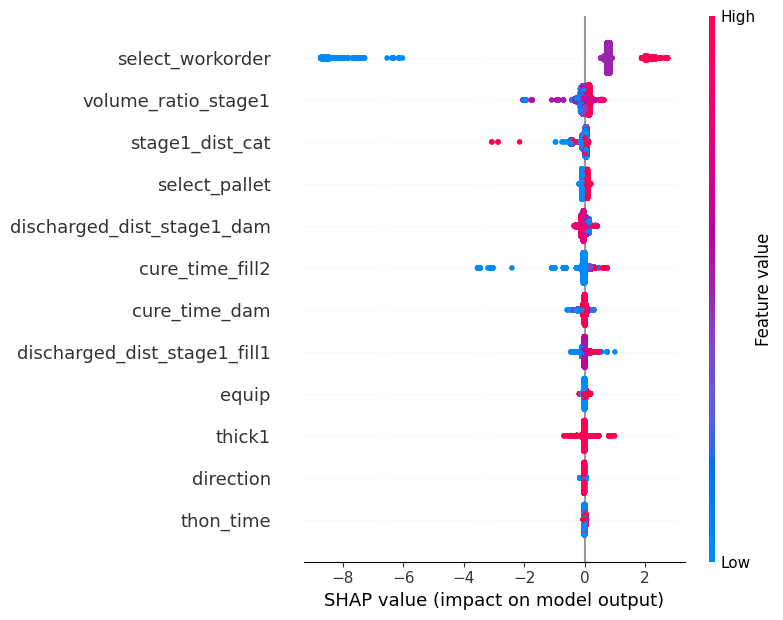

In [30]:
explainer = shap.Explainer(stage1_best_model)
shap_values = explainer(test_stage1_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage1_x)

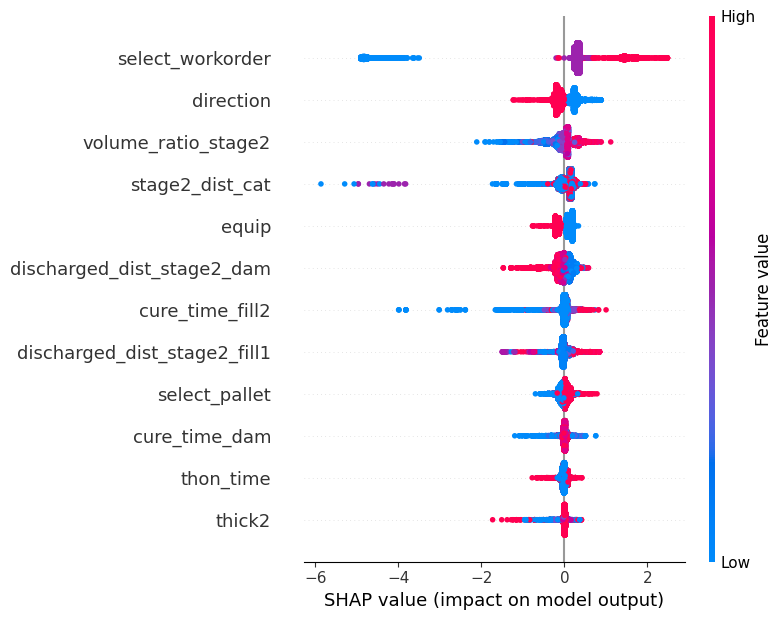

In [31]:
explainer = shap.Explainer(stage2_best_model)
shap_values = explainer(test_stage2_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage2_x)

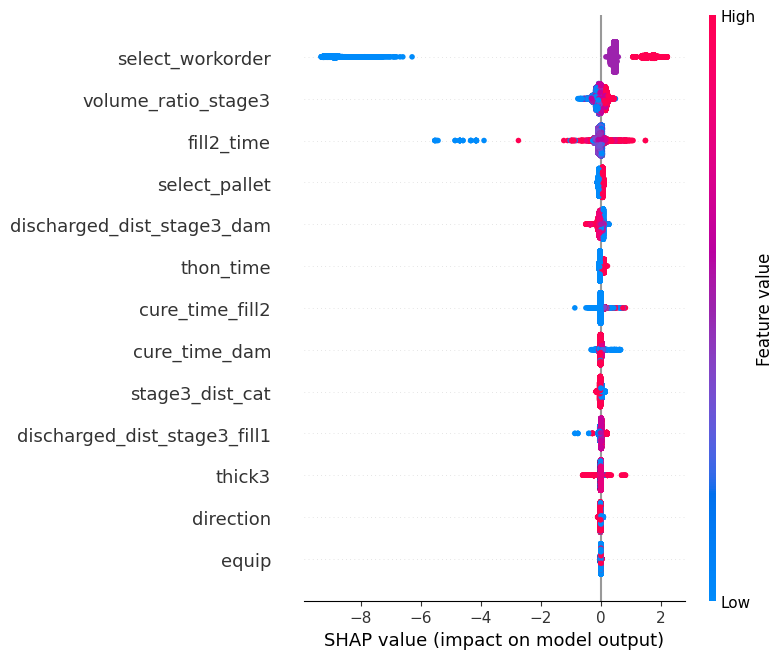

In [32]:
explainer = shap.Explainer(stage3_best_model)
shap_values = explainer(test_stage3_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage3_x)

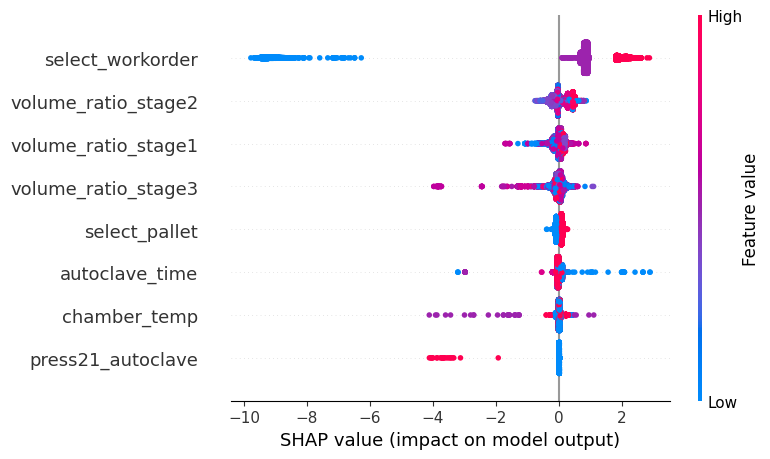

In [33]:
explainer = shap.Explainer(AutoClave_best_model)
shap_values = explainer(test_AutoClave_x)
shap.initjs()

shap.summary_plot(shap_values, test_AutoClave_x)

In [34]:
stage1_test_pred = stage1_best_model.predict(test_stage1_x)
stage1_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
stage2_test_pred = stage2_best_model.predict(test_stage2_x)
stage2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
stage3_test_pred = stage3_best_model.predict(test_stage3_x)
stage3_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
AutoClave_test_pred = AutoClave_best_model.predict(test_AutoClave_x)
AutoClave_test_pred

array([0, 0, 0, ..., 0, 1, 0])

In [38]:
result = np.logical_or(stage1_test_pred, stage2_test_pred)
result = np.logical_or(result, stage3_test_pred)
result = np.logical_or(result, AutoClave_test_pred)

In [39]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [40]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 2390, 14971]))

In [41]:
test['target'] = y_pred

In [42]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,2379,14954
1,11,17


In [43]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [44]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,2379,14954
1,28,0


In [45]:
test.columns

Index(['Set ID', 'inconsistant', 'stage1_dist_cat', 'stage2_dist_cat',
       'stage3_dist_cat', 'cure_time_dam', 'cure_time_fill2',
       'press21_autoclave', 'thon_time', 'discharged_dist_stage1_dam',
       'discharged_dist_stage2_dam', 'discharged_dist_stage3_dam',
       'discharged_dist_stage1_fill1', 'discharged_dist_stage2_fill1',
       'discharged_dist_stage3_fill1', 'equip', 'fill2_time', 'autoclave_time',
       'qty', 'thick1', 'thick2', 'thick3', 'chamber_temp', 'model_suffix',
       'select_workorder', 'select_pallet', 'direction', 'volume_ratio_stage1',
       'volume_ratio_stage2', 'volume_ratio_stage3', 'target'],
      dtype='object')

<Axes: >

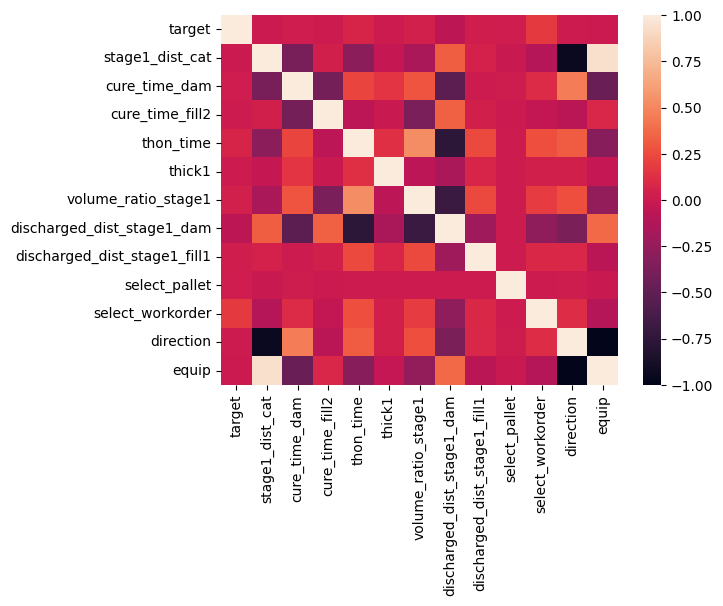

In [46]:
sns.heatmap(df_stage1.corr(), vmin=-1, vmax=1)

<Axes: >

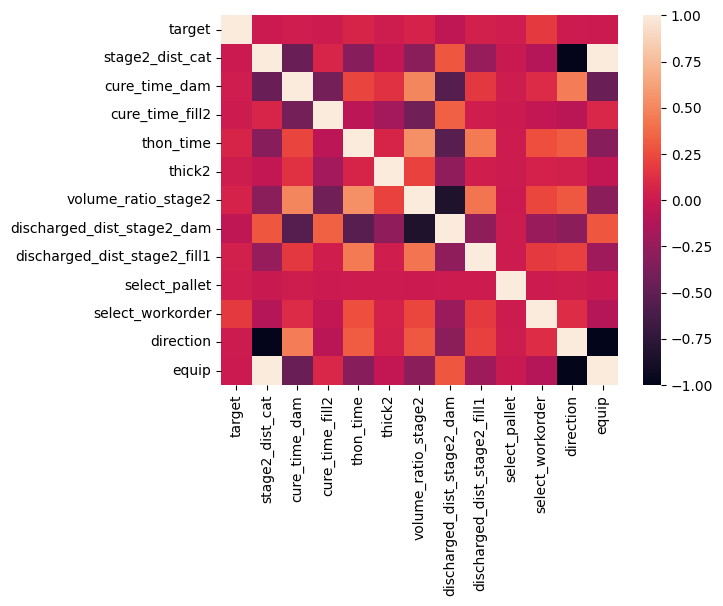

In [47]:
sns.heatmap(df_stage2.corr(), vmin=-1, vmax=1)

<Axes: >

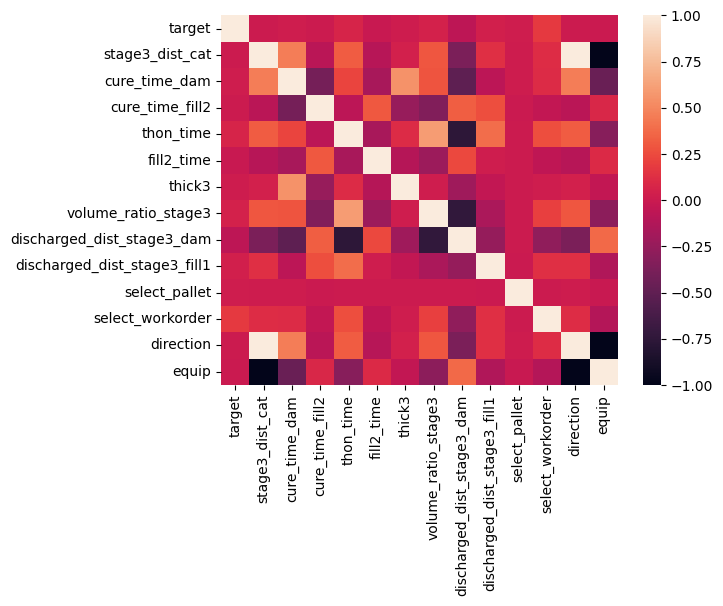

In [48]:
sns.heatmap(df_stage3.corr(), vmin=-1, vmax=1)

<Axes: >

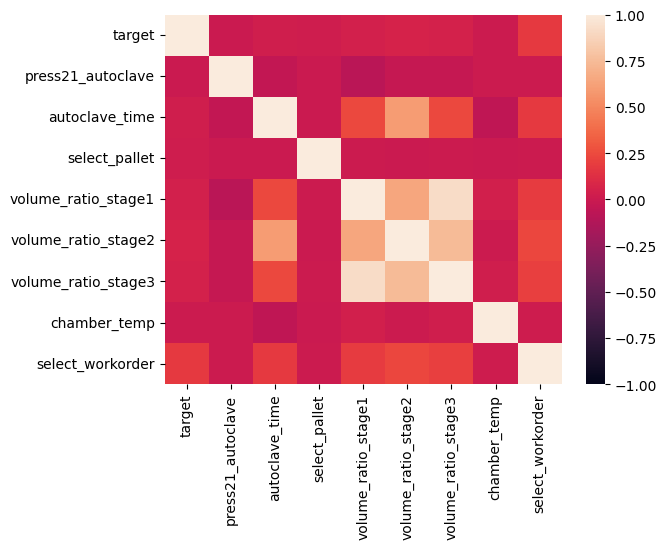

In [49]:
sns.heatmap(df_autoclave.corr(), vmin=-1, vmax=1)

<Axes: >

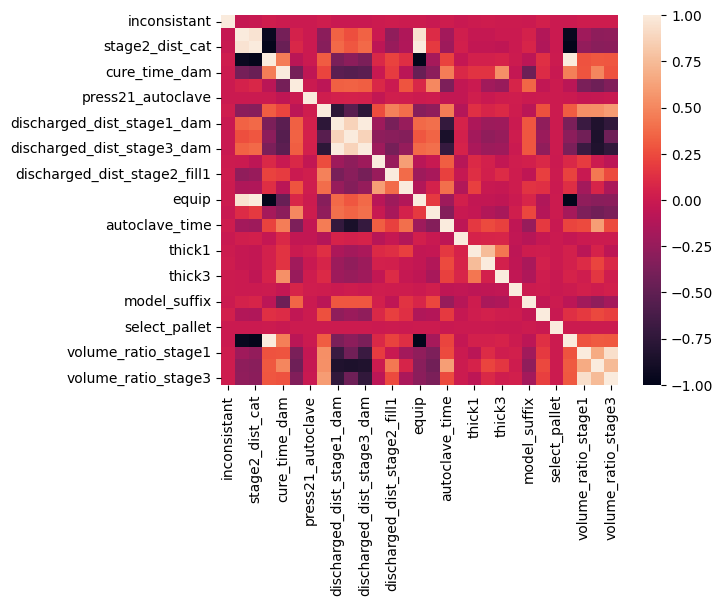

In [50]:
sns.heatmap(test.iloc[:, 1:-1].corr(), vmin=-1, vmax=1)

In [51]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)